<a href="https://colab.research.google.com/github/IrinaChen/Banking-Analytics-2020---Deep-Learning/blob/main/%E2%80%9CCoursework03Q2-VGG19%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!gdown "https://drive.google.com/file/d/1Go7Kk1Una5ssoiSHYF70LR9Jrve2eS-Q/view?usp=sharing"

/usr/local/lib/python2.7/dist-packages/gdown/parse_url.py:31: UserWarning: You specified Google Drive Link but it is not the correct link to download the file. Maybe you should try: https://drive.google.com/uc?id=1Go7Kk1Una5ssoiSHYF70LR9Jrve2eS-Q
  .format(url='https://drive.google.com/uc?id={}'.format(file_id))
Downloading...
From: https://drive.google.com/file/d/1Go7Kk1Una5ssoiSHYF70LR9Jrve2eS-Q/view?usp=sharing
To: /content/view?usp=sharing
62.9kB [00:00, 992kB/s]


In [ ]:
!unzip '/content/drive/My Drive/DataC3FM95282020.zip'

##VGG19

In [ ]:
import numpy as np
import h5py as h5py
import PIL

# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

In [ ]:
model = VGG19(weights = 'imagenet',      # The weights from the ImageNet competition
              include_top = False,       # Do not include the top layer, which classifies.
              input_shape= (224, 224, 3) # Input shape. Three channels, and BGR (NOT RGB!!!)
             )
#for layer in model.layers:
#  layer.trainable = False 

We can now check the details of the model:

VGG19 model graph

Output Layer: SoftMax (It is used in multinomial logistic regression )

We need a categorical corss-entropy 

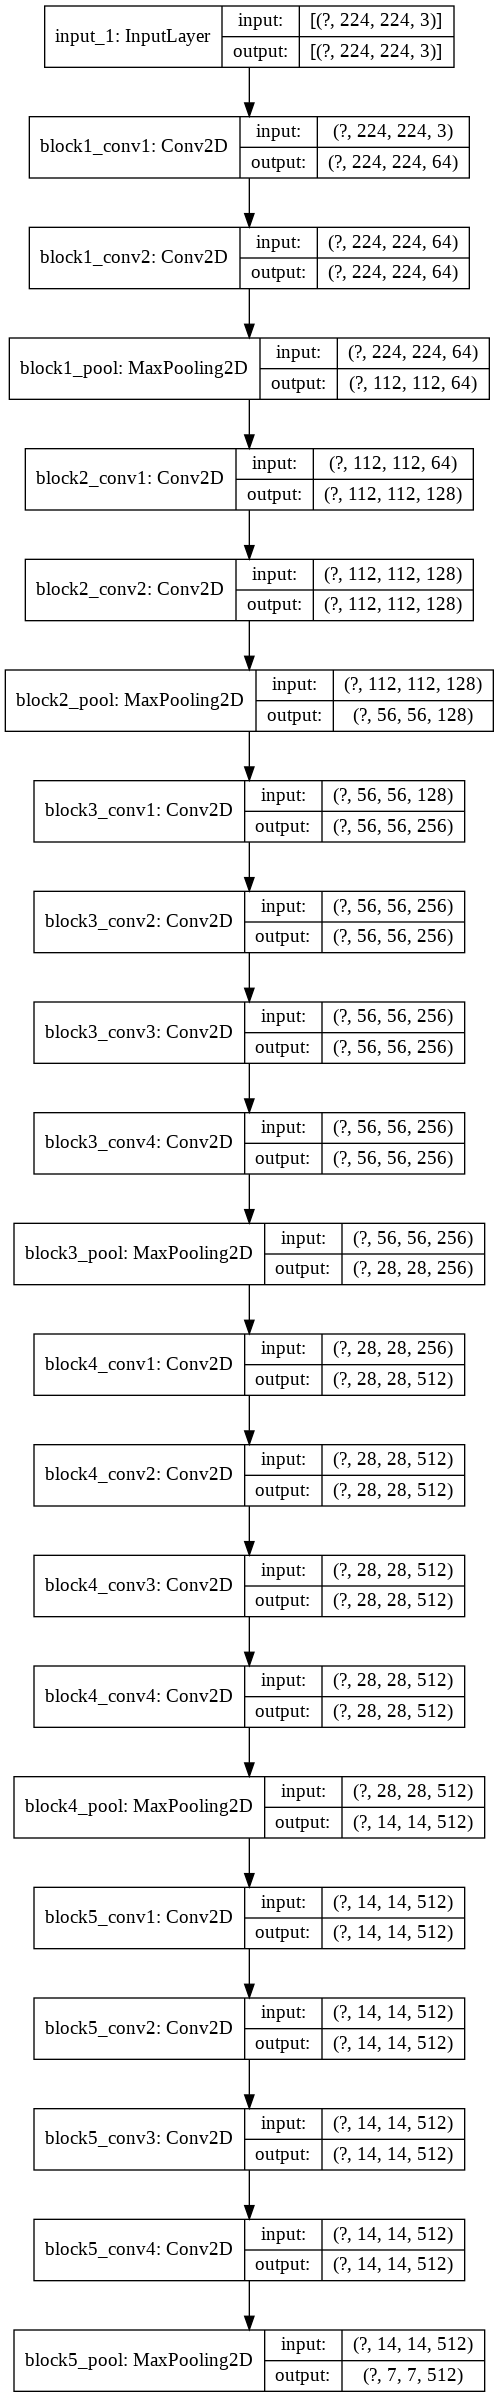

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

Import Sequential because VGG is sequential;
Import all types of layers from Keras 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

Create my own model that will copy the VGG19 model to my
model:

Q: what layers do I train? 

the more trainable layers that I set, the longer it's going 
to take;However, the more accuracte the result can potentially 
be.

We need more trainable layers to our satellite images


In [ ]:
# Create new model
MyModel = Sequential()

# Copy the layers to our new model. This needs to be done as there is a bug in Keras.
for layer in model.layers:
    MyModel.add(layer)

# Set the layers as untrainable
for layer in MyModel.layers:
    layer.trainable = False

In [ ]:
MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

Start to train my layers (take the last two layers):

Layers counts start from 0 

In [ ]:
# Set layer as trainable.
#MyModel.layers[16].trainable = True
#MyModel.layers[17].trainable = True
#MyModel.layers[18].trainable = True
MyModel.layers[19].trainable = True

Because the output of the layer is Tensor, howerver,
the dense layer does not accept Tensor, it only accepts 
a flatten vector, therefore, we need to add a "Flattern" function
(take the input and flatten it; the input shape is simply the 
output shape of the original model)



In [ ]:
MyModel.add(Flatten(input_shape=model.output_shape[1:]))

In [ ]:
# We now add the new layers for prediction.
MyModel.add(Dense(1920, activation = 'relu'))
MyModel.add(Dropout(0.5))
MyModel.add(Dense(960, activation = 'relu'))
MyModel.add(Dropout(0.5))
MyModel.add(Dense(1, activation = 'sigmoid')) # and a output layer

In [ ]:
# How does the model look like?
MyModel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

Now our model needs to train 11074178 parameters!

In [ ]:
# Compiling the model!
MyModel.compile(loss='binary_crossentropy', 
              optimizer='adam',
              #optimizer=optimizers.Adadelta(learning_rate=0.01), # try to get as big number as you can but might end
              # up with getting nothing 
              #metrics=[keras.metrics.MeanSquaredError()]
              metrics = ["AUC"] # Because this problem is not binary also applies to binary
              )

 We have our set of pictures ready for this example. For this problem we will use a generator. A generator takes images from a directory, and feeds them to the model as needed. **This is necessary to work with big data**. We cannot expect the datasets we work here to fit in memory, so we take the images as needed.

We will first build two image generators (one for testing and one for training), which will generate new samples on the fly using our pictures as input.

We will also conduct **data augmentation**, which are a series of mathematical operations over the datasets to make them search more complex patterns. If you use augmentation, learning will take longer but be more robust. The process to work with this data is the following:

1. Create an [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) object which will process the images and load them as needed.

2. Call the ```flow_from_directory``` from our generator which will split the data into two parts, one for training and one for validation.

If the dataset has lots of diversity, then we should make the Generator Diversity as well (only for train set! test set did not need any Diversity!)

Batch_size = unknown, keep trying until your co-lab explode. Will increase the speed of trainning!

In [ ]:
# prepare data augmentation configuration. One for train, one for test.
# Data Generator:
train_datagen = ImageDataGenerator(
                                  rescale=1. / 255,                         # NNets like small inputs. Rescale.
                                  shear_range=0.2,                          # Shear? Increase diagonal angel 
                                  zoom_range=0.2,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=True,                     # Flip horizontally? Mirror Image
                                  vertical_flip=True,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # VGG expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0.2                    # Create a validation dataset and a trainning set 
                                  )

test_datagen = ImageDataGenerator(
                                  rescale=1. / 255,                       # NNets like small inputs. Rescale.
                                  shear_range=0,                          # Shear?
                                  zoom_range=0,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=False,                  # Flip horizontally?
                                  vertical_flip=False,                    # Flip vertically?
                                  preprocessing_function=preprocess_input,# VGG expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0                    # No validation cut for test.
                                  )


# We will use a batch size of 64. Depends on RAM of GPU.
batch_size = 8

# Train data generator. We point to the training directory!
train_data_dir = "Data/train"

# VGG requires 224 x 224 images.
(img_height, img_width) = (224, 224)

# Batch Generator:
train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,                      # Where are the pics
                                                    target_size=(img_height, img_width), # What size should they be
                                                    batch_size=batch_size,               # Size of batch: how many images to return: 64
                                                    class_mode='binary',            # Class mode, whether 'binary' or 'categorical'
                                                    subset = 'training',                 # What subset to use? Only works when we have validation_split in the above
                                                    shuffle = True                       # Shuffle the data?
                                                    )

validation_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,                      # Where are the pics
                                                    target_size=(img_height, img_width), # What size should they be
                                                    batch_size=batch_size,               # Size of batch
                                                    class_mode='binary',            # Class mode, whether 'binary' or 'categorical'
                                                    subset = 'validation',               # What subset to use?
                                                    shuffle = True                       # Shuffle the data?
                                                    )

# Test data generator.
test_data_dir = "Data/test"
test_generator = test_datagen.flow_from_directory(
                                                  test_data_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=1, # take the image one by one
                                                  class_mode='binary',
                                                  shuffle = False
                                                  )

Found 3988 images belonging to 2 classes.
Found 996 images belonging to 2 classes.
Found 2142 images belonging to 2 classes.


 We found the following datasets:

* Train: 3988 images belonging to 2 classes.
* Validation: 996 images belonging to 2 classes.
* Test: 2142 images belonging to 2 classes.

Now I train:

Will take a while

In [ ]:
# Batch size:
epoch_step = (996/64)
epoch_step

15.5625

In [ ]:
# Number of epochs
epochs = 20

# Train!
MyModel.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            steps_per_epoch = 80, # Usually cases / batch_size = 3998/64. Reduced to 15 so it runs faster.
            validation_steps = 20 # Number of validation steps. Again cases / batch_size = 15.
          )

Keep an eyes on the loss and validation_loss: we want full converges graph.
If val_loss starts goes up again, we stop trainning, we want the 
val_loss line to be flat.

Flat at the end of the graph



In [ ]:
loss = MyModel.history.history['loss']
val_loss = MyModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now, let's apply it to the test set and get a confusion matrix.

In [ ]:
# Applying to the test set with a generator.
test_generator.reset()

# Get probabilities
output = MyModel.predict(test_generator)

In [ ]:
output

array([[0.35683206],
       [0.35683206],
       [0.35683206],
       ...,
       [0.35683206],
       [0.35683206],
       [0.35683206]], dtype=float32)

In [ ]:
# Calculate classes
#pred_classes = np.argmax(output, axis=1) # What the model predicts
pred_classes = output

labels = test_generator.classes # What the truth is 

In [ ]:
pred_classes

array([[0.37006766],
       [0.37006766],
       [0.37006766],
       ...,
       [0.37006766],
       [0.36981216],
       [0.37006766]], dtype=float32)

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(labels, pred_classes)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = labels, 
                             y_score = pred_classes),
              decimals = 4)

# Create and show the plot
plt.plot(fpr,tpr,label="logreg, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline

# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = labels, 
                    y_pred = pred_classes)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net, 
        index=['0','1'],
        columns=['0','1'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()